<a href="https://colab.research.google.com/github/CamiloVga/Curso-Inteligencia-Artificial/blob/main/Clase_FineTuning_TextGen_BaseStream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch
!pip install transformers
!pip install datasets
!pip install peft

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 6.8 MB/s eta 0:00:00


In [2]:
# Importar las librerías necesarias
!pip install -U bitsandbytes accelerate transformers
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling, BitsAndBytesConfig
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
import random
import matplotlib.pyplot as plt
from transformers import TrainerCallback

# Cargar el dataset con streaming y tomar 100 ejemplos aleatorios
dataset = load_dataset("othorizedshogun/poems_dataset", split="train", streaming=True)
dataset = dataset.shuffle(seed=42).take(100)

# Cargar el modelo y el tokenizador
model_name = "microsoft/phi-2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Función para preprocesar el dataset
def preprocess_function(example):
    text = f"<s>[INST] {example['input']} [/INST] {example['poem']} </s>"
    return tokenizer(text, truncation=True, padding="max_length", max_length=512)

# Aplicar el preprocesamiento
tokenized_dataset = dataset.map(preprocess_function)




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 472.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 30.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.34.2
    Uninstalling accelerate-0.34.2:
      Successfully uninstalled accelerate-0.34.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2


README.md:   0%|          | 0.00/500 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Unused kwargs: ['bnb_8bit_use_double_quant', 'bnb_8bit_quant_type', 'bnb_8bit_compute_dtype']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:316: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', arg

Step,Training Loss
5,2.344600
10,2.365500
15,2.192700
20,2.083300
25,1.974500
30,2.227400
35,1.972600
40,1.877700
45,1.927600
50,2.011600


Step: 5, Loss: 2.3446
Step: 10, Loss: 2.3655
Step: 15, Loss: 2.1927
Step: 20, Loss: 2.0833
Step: 25, Loss: 1.9745
Step: 30, Loss: 2.2274
Step: 35, Loss: 1.9726
Step: 40, Loss: 1.8777
Step: 45, Loss: 1.9276
Step: 50, Loss: 2.0116


/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:316: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cp

Step: 55, Loss: 1.9736
Step: 60, Loss: 1.9589
Step: 65, Loss: 1.8876
Step: 70, Loss: 2.0566
Step: 75, Loss: 1.8848
Step: 80, Loss: 1.9463
Step: 85, Loss: 2.045
Step: 90, Loss: 1.8687
Step: 95, Loss: 1.8894
Step: 100, Loss: 2.0113


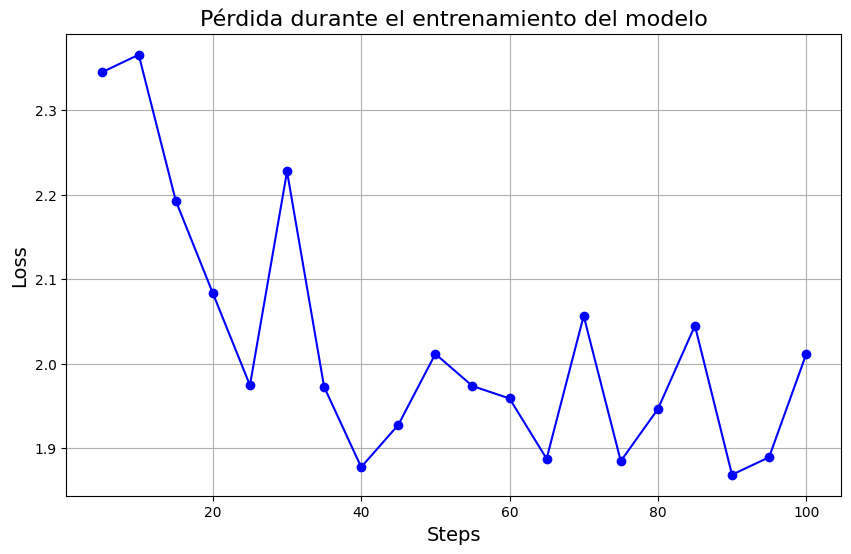

In [8]:
# Configurar BitsAndBytesConfig para cuantización de 8 bits
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_use_double_quant=True,
    bnb_8bit_quant_type="nf4",
    bnb_8bit_compute_dtype=torch.float16
)

# Configurar el modelo para entrenamiento de 8-bit
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)
model = prepare_model_for_kbit_training(model)

# Configuración de LoRA (Low-Rank Adaptation) para PEFT (Parameter-Efficient Fine-Tuning)
peft_config = LoraConfig(
    r=16,
    # r: Rango de las matrices de actualización LoRA.
    # - Determina la complejidad y capacidad del ajuste.
    # - Valores más altos permiten más flexibilidad pero aumentan los parámetros entrenables.
    # - Valores típicos: 8, 16, 32. Ajustar según la complejidad de la tarea y recursos disponibles.

    lora_alpha=32,
    # lora_alpha: Factor de escala para las actualizaciones LoRA.
    # - Controla la magnitud de las actualizaciones LoRA en relación con los pesos originales.
    # - Generalmente se establece como 2 * r para un buen equilibrio.
    # - Valores más altos pueden llevar a un aprendizaje más rápido pero potencialmente inestable.

    lora_dropout=0.05,
    # lora_dropout: Tasa de dropout aplicada a las capas LoRA.
    # - Ayuda a prevenir el sobreajuste introduciendo regularización.
    # - Valores típicos: 0.1, 0.05, 0.01. Ajustar según el tamaño del dataset y la tendencia al sobreajuste.

    bias="none",
    # bias: Determina si y cómo se ajustan los sesgos (biases) del modelo.
    # - "none": No se ajustan los sesgos, solo los pesos.
    # - "all": Se ajustan todos los sesgos.
    # - "lora_only": Solo se ajustan los sesgos en las capas LoRA.
    # Generalmente, "none" es suficiente para muchas tareas.

    task_type="CAUSAL_LM"
    # task_type: Especifica el tipo de tarea para la que se está ajustando el modelo.
    # - "CAUSAL_LM": Para modelos de lenguaje causal (generación de texto).
    # - Otros valores posibles: "SEQ_CLS" (clasificación de secuencias), "SEQ_2_SEQ_LM" (seq2seq), etc.
    # Asegura que LoRA se aplique correctamente según el tipo de modelo y tarea.
)

# Notas adicionales:
# - LoRA es eficiente en términos de parámetros, permitiendo fine-tuning con recursos limitados.
# - La combinación de estos parámetros afecta el rendimiento y la eficiencia del fine-tuning.
# - Es recomendable experimentar con diferentes valores para optimizar resultados.


model = get_peft_model(model, peft_config)

# Crear el callback para registrar las pérdidas
class LossCallback(TrainerCallback):
    def __init__(self):
        self.losses = []
        self.steps = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if "loss" in logs:
            print(f"Step: {state.global_step}, Loss: {logs['loss']}")  # Depuración
            self.losses.append(logs["loss"])
            self.steps.append(state.global_step)

# Instanciar el callback
loss_callback = LossCallback()

# Configurar los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./results",  # Carpeta de salida
    num_train_epochs=3,  # Número de épocas de entrenamiento
    per_device_train_batch_size=4,  # Tamaño del batch por dispositivo
    gradient_accumulation_steps=4,  # Acumular gradientes para 4 pasos
    warmup_steps=50,  # Número de pasos de warmup
    learning_rate=5e-4,  # Tasa de aprendizaje
    fp16=True,  # Usar media precisión (16 bits)
    logging_steps=5,  # Registrar cada 5 pasos
    save_steps=50,  # Guardar el modelo cada 50 pasos
    max_steps=100  # Número máximo de pasos de entrenamiento
)

# Preparar el data collator
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Inicializar el Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator,
    callbacks=[loss_callback]  # Agregar el callback para registrar las pérdidas
)

# Entrenar el modelo
trainer.train()

# Guardar el modelo
trainer.save_model("./fine_tuned_phi2_poems")

# Graficar la función de pérdida después del entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(loss_callback.steps, loss_callback.losses, marker='o', linestyle='-', color='b')
plt.title('Pérdida durante el entrenamiento del modelo', fontsize=16)
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True)
plt.show()

In [9]:
#Inferencia

import torch

# Asegurarse de que el modelo esté en el dispositivo correcto
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Función de inferencia usando el modelo entrenado
def inferencia_generacion_texto(prompt, model, tokenizer, max_length=200):
    # Asegurarse de que el prompt tiene el formato correcto
    if not prompt.startswith("<s>[INST]"):
        prompt = f"<s>[INST] {prompt} [/INST]"

    # Tokenizar el prompt y mover los tensores al dispositivo correcto
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)

    # Realizar la inferencia
    with torch.no_grad():
        outputs = model.generate(
            inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_length=max_length,
            num_return_sequences=1,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            top_k=50,
            no_repeat_ngram_size=3,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    # Decodificar la salida
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Limpiar el texto generado
    generated_text = generated_text.replace(prompt, "").strip()
    generated_text = ' '.join(generated_text.split())  # Eliminar espacios extra

    return generated_text

# Ejemplo de uso del módulo de inferencia después del entrenamiento
nuevo_prompt = "Escribe un poema sobre la luna"
resultado = inferencia_generacion_texto(nuevo_prompt, model, tokenizer)
print(f"Prompt: {nuevo_prompt}\n")
print("Poema generado:")
print(resultado)

# Generar otro poema
otro_prompt = "Crea un poema sobre el amor"
otro_resultado = inferencia_generacion_texto(otro_prompt, model, tokenizer)
print(f"\nPrompt: {otro_prompt}\n")
print("Poema generado:")
print(otro_resultado)

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:316: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Prompt: Escribe un poema sobre la luna

Poema generado:
Pues, más de la luz que el sol, Poem: Puede ver la lune, la estrella de la ciudad donde se han cieladas años, o en la estela de la noche que en la ciencia se hayan más cerca del la ciela que la cintura del viento cuando las nubes caminan por la cuerda de los ramas del vino, y cuando el viente es tan arcoísmo que el vino se esconde en los ramos, puede mirar la luciérnaga de la espina que se enfrenta a la luce de la oscura, bajo la cárcel de la est

Prompt: Crea un poema sobre el amor

Poema generado:
El amor es la cama de la sombra, Poema de una niña que se había perdido, Y la mujer que se lo hizo. El cielo no es la sopa de sores, El corazón no es el árbol de sombreros, Los sueños no es las palmas de las palabras. Los hombres no son los cántidos de pájaros, La mujercita no es una mujerta de palo, Las mujeres no es suerte que más, De una palma de música, No es suavidad que mústica. ¿Qué es el amo que se hizo? Es la
